In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os

%matplotlib notebook
#%matplotlib inline

from ipywidgets import interact #, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
fol = '/home/alessio/x-last_Stuff'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir not in ['HTML','csv']])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> b-UV-0.22_0000
1 -> m-IR-Polarized-NOR_0000
2 -> m-only_IR_middle140-9331_0000
3 -> m-only_IR_middle140_0000
4 -> m-only_IR_middle140_div10_0000
5 -> z-from1_0000



In [15]:
def create_df_from_files_given_name(name,fol,fs_end_pulse):
    '''
    This creates the excel file from the 4 files
    '''
    project_folder = os.path.join(fol,name)
    
    output_norm = os.path.join(project_folder, 'output')
    output_popu = os.path.join(project_folder, 'outputPopul')
    output_abso = os.path.join(project_folder, 'Output_Abs')
    output_regi = os.path.join(project_folder, 'Output_Regions')
    
    df_norm2 = pd.read_csv(output_norm, delim_whitespace=True, index_col=0, names=['counter', 'steps', 'fs','Norm deviation','Kinetic','Potential','Total','Total Deviation','Xpulse','Ypulse','Zpulse','AbZino'])
    df_popu2 = pd.read_csv(output_popu, delim_whitespace=True, names=['fs', 'S0', 'S1','S2','S3','S4','S5','S6','S7'])
    df_abso2 = pd.read_csv(output_abso, delim_whitespace=True, names=['Time AU', 'Abs Tot', 'Abs S0', 'Abs S1','Abs S2','Abs S3','Abs S4','Abs S5','Abs S6','Abs S7'])
    df_regi2 = pd.read_csv(output_regi, delim_whitespace=True, names=['FC','Reactants','Products'])
    

    # I need to cut down to different file size <- this will become obsolete
    dfs = [df_norm2,df_popu2,df_abso2,df_regi2]
    lengths = min([x.shape[0] for x in dfs])
    
    df_norm, df_popu, df_abso, df_regi = [ x.drop(x.index[lengths:]) for x in dfs ]
    
    AU_dt = df_abso['Time AU'].iloc[1]
    
    #fs_end_pulse = 15 # this is where I start to count Fc population retourning in S0 after the pulse.
    fs_array = df_norm2['fs']
    filtering_on_indexes = np.arange(lengths)
#     number_line_after_pulse = np.where(fs_array > fs_end_pulse)[0][0]
    number_line_after_pulse = 200
    
    fs_after_pulse = df_popu['fs'].iloc[number_line_after_pulse]
    s0_after_pulse = df_popu['S0'].iloc[number_line_after_pulse]
    s1_after_pulse = df_popu['S1'].iloc[number_line_after_pulse]
    s2_after_pulse = df_popu['S2'].iloc[number_line_after_pulse]
    s3_after_pulse = df_popu['S3'].iloc[number_line_after_pulse]
    s4_after_pulse = df_popu['S4'].iloc[number_line_after_pulse]
    s5_after_pulse = df_popu['S5'].iloc[number_line_after_pulse]
    s6_after_pulse = df_popu['S6'].iloc[number_line_after_pulse]
    s7_after_pulse = df_popu['S7'].iloc[number_line_after_pulse]
    
    all_after_pulse = np.array([s0_after_pulse,s1_after_pulse,s2_after_pulse,s3_after_pulse,s4_after_pulse,s5_after_pulse,s6_after_pulse,s7_after_pulse])
    
    if number_line_after_pulse != 0:
        value_to_subtract = df_regi['FC'].iloc[number_line_after_pulse-1]
        df_regi['FC after pulse'] = np.where( filtering_on_indexes < number_line_after_pulse, 0, (df_regi['FC']-value_to_subtract))
    else:
        df_regi['FC after pulse'] = df_regi['FC']
        
    df_all = pd.concat([df_norm,df_popu,df_abso,df_regi],axis=1)
    
    csv_name = '{}.csv'.format(project_folder)
    
    print('{} #steps {} - End pulse {} - S1: {:8.5E} - S2: {:8.5E} - S3: {:8.5E} - S4: {:8.5E} {}'.format(AU_dt,lengths, fs_after_pulse,s1_after_pulse,s2_after_pulse,s3_after_pulse,s4_after_pulse,name))
    
    # ok this part needs comment. We want to normalize the S1 population to 1, to make the absorbed product count "fair"
    # But the population in S1 is "moving" due to the other states continuosly absorbing/feeding it
    # We make the assumption that all the other states are a single superstate that "feeds" only S1.
    # So we sum up states from S2 to S7. Then we take the population of those states (2 to 7) after the pulse. We want to 
    # know after the pulse what is the CHANGE in population due to NAC of this "super state".
    # our normalization factor for S1 at time T is ten the 
    
    df_all['sum_others'] = (df_all['S2'] + df_all['S3'] + df_all['S4'] + df_all['S5'] + df_all['S6'] + df_all['S7'])
    df_all['sum_others_minus_after_pulse'] = sum(all_after_pulse[2:]) - df_all['sum_others']
    df_all['Norm_factor (t)'] = all_after_pulse[1] + df_all['sum_others_minus_after_pulse']
    
    df_all['P(t) Tot'] = -(np.cumsum(df_all['Abs Tot'])*AU_dt)
    df_all['P(t) S0'] =  -(np.cumsum(df_all['Abs S0'])*AU_dt)
    df_all['P(t) S1'] =  -(np.cumsum(df_all['Abs S1'])*AU_dt)
    df_all['P(t) S2'] =  -(np.cumsum(df_all['Abs S2'])*AU_dt)
    df_all['P(t) S3'] =  -(np.cumsum(df_all['Abs S3'])*AU_dt)
    df_all['P(t) S4'] =  -(np.cumsum(df_all['Abs S4'])*AU_dt)
    df_all['P(t) S5'] =  -(np.cumsum(df_all['Abs S5'])*AU_dt)
    df_all['P(t) S6'] =  -(np.cumsum(df_all['Abs S6'])*AU_dt)
    df_all['P(t) S7'] =  -(np.cumsum(df_all['Abs S7'])*AU_dt)
    
    df_all['AU_dt'] = AU_dt
    
    df_all['Products_F']  = df_all['Products']  + df_all['P(t) S0']
    #df_all['Reactants_F'] = df_all['Reactants'] + df_all['FC after pulse']
    df_all['Reactants_F'] = df_all['Reactants']
    
#     df_all['Real Reactants'] = df_regi['Reactants'] + df_regi['FC after pulse']
#     df_all['Real Products'] = df_regi['Products'] + df_abso['Norm S0']
#     df_all['Real ratio'] = df_all['Real Products']/df_all['Real Reactants']
    
    df_all.to_csv(csv_name)
    
    #df_all.plot('fs',['Reactants','Products'])
    #df_all.plot('fs','ratio')
    #df_all.plot('fs',['Real Reactants','Real Products'])
    #return(df_all[['fs','Norm_factor (t)','sum_others_minus_after_pulse','sum_others']])
    #return(df_all[['Norm Tot','fs','ratio','Real Products','Real Reactants','Abs S0','Norm S0', 'Products', 'Reactants','Real ratio','S1','S2','S3','S0','S4','S5','S6','S7','Xpulse','Ypulse','Norm_factor (t)','sum_others_minus_after_pulse','sum_others','Norm deviation','Absorbed Normalized','FC after pulse']])
    return(df_all)
    
number = 3

a = create_df_from_files_given_name('m-only_IR_middle140_0000',fol,26)
b = create_df_from_files_given_name('b-UV-0.22_0000',fol,15)
c = create_df_from_files_given_name('m-only_IR_middle140_div10_0000',fol,26)
d = create_df_from_files_given_name('m-IR-Polarized-NOR_0000',fol,15)
e = create_df_from_files_given_name('z-from1_0000',fol,0)
f = create_df_from_files_given_name('m-only_IR_middle140-9331_0000',fol,26)


2.0671 #steps 1568 - End pulse 10.01 - S1: 9.35392E-04 - S2: 1.15244E-04 - S3: 1.97293E-04 - S4: 3.12872E-05 m-only_IR_middle140_0000
2.0671 #steps 1301 - End pulse 10.01 - S1: 2.55213E-01 - S2: 7.56101E-03 - S3: 7.86268E-03 - S4: 1.64050E-02 b-UV-0.22_0000
2.0671 #steps 973 - End pulse 10.01 - S1: 9.33378E-04 - S2: 4.64398E-05 - S3: 1.63529E-04 - S4: 2.43433E-05 m-only_IR_middle140_div10_0000
2.0671 #steps 1541 - End pulse 10.01 - S1: 8.78358E-02 - S2: 6.41204E-02 - S3: 4.55731E-02 - S4: 2.01075E-03 m-IR-Polarized-NOR_0000
2.0671 #steps 1077 - End pulse 10.01 - S1: 9.78240E-01 - S2: 9.26010E-03 - S3: 5.78564E-03 - S4: 3.00519E-03 z-from1_0000
2.0671 #steps 208 - End pulse 10.01 - S1: 9.47996E-04 - S2: 1.14786E-04 - S3: 1.98760E-04 - S4: 3.30717E-05 m-only_IR_middle140-9331_0000


In [16]:
colors = ['b', 'g', 'r', 'm', 'c', 'y', 'k', 'mediumpurple']

<IPython.core.display.Javascript object>


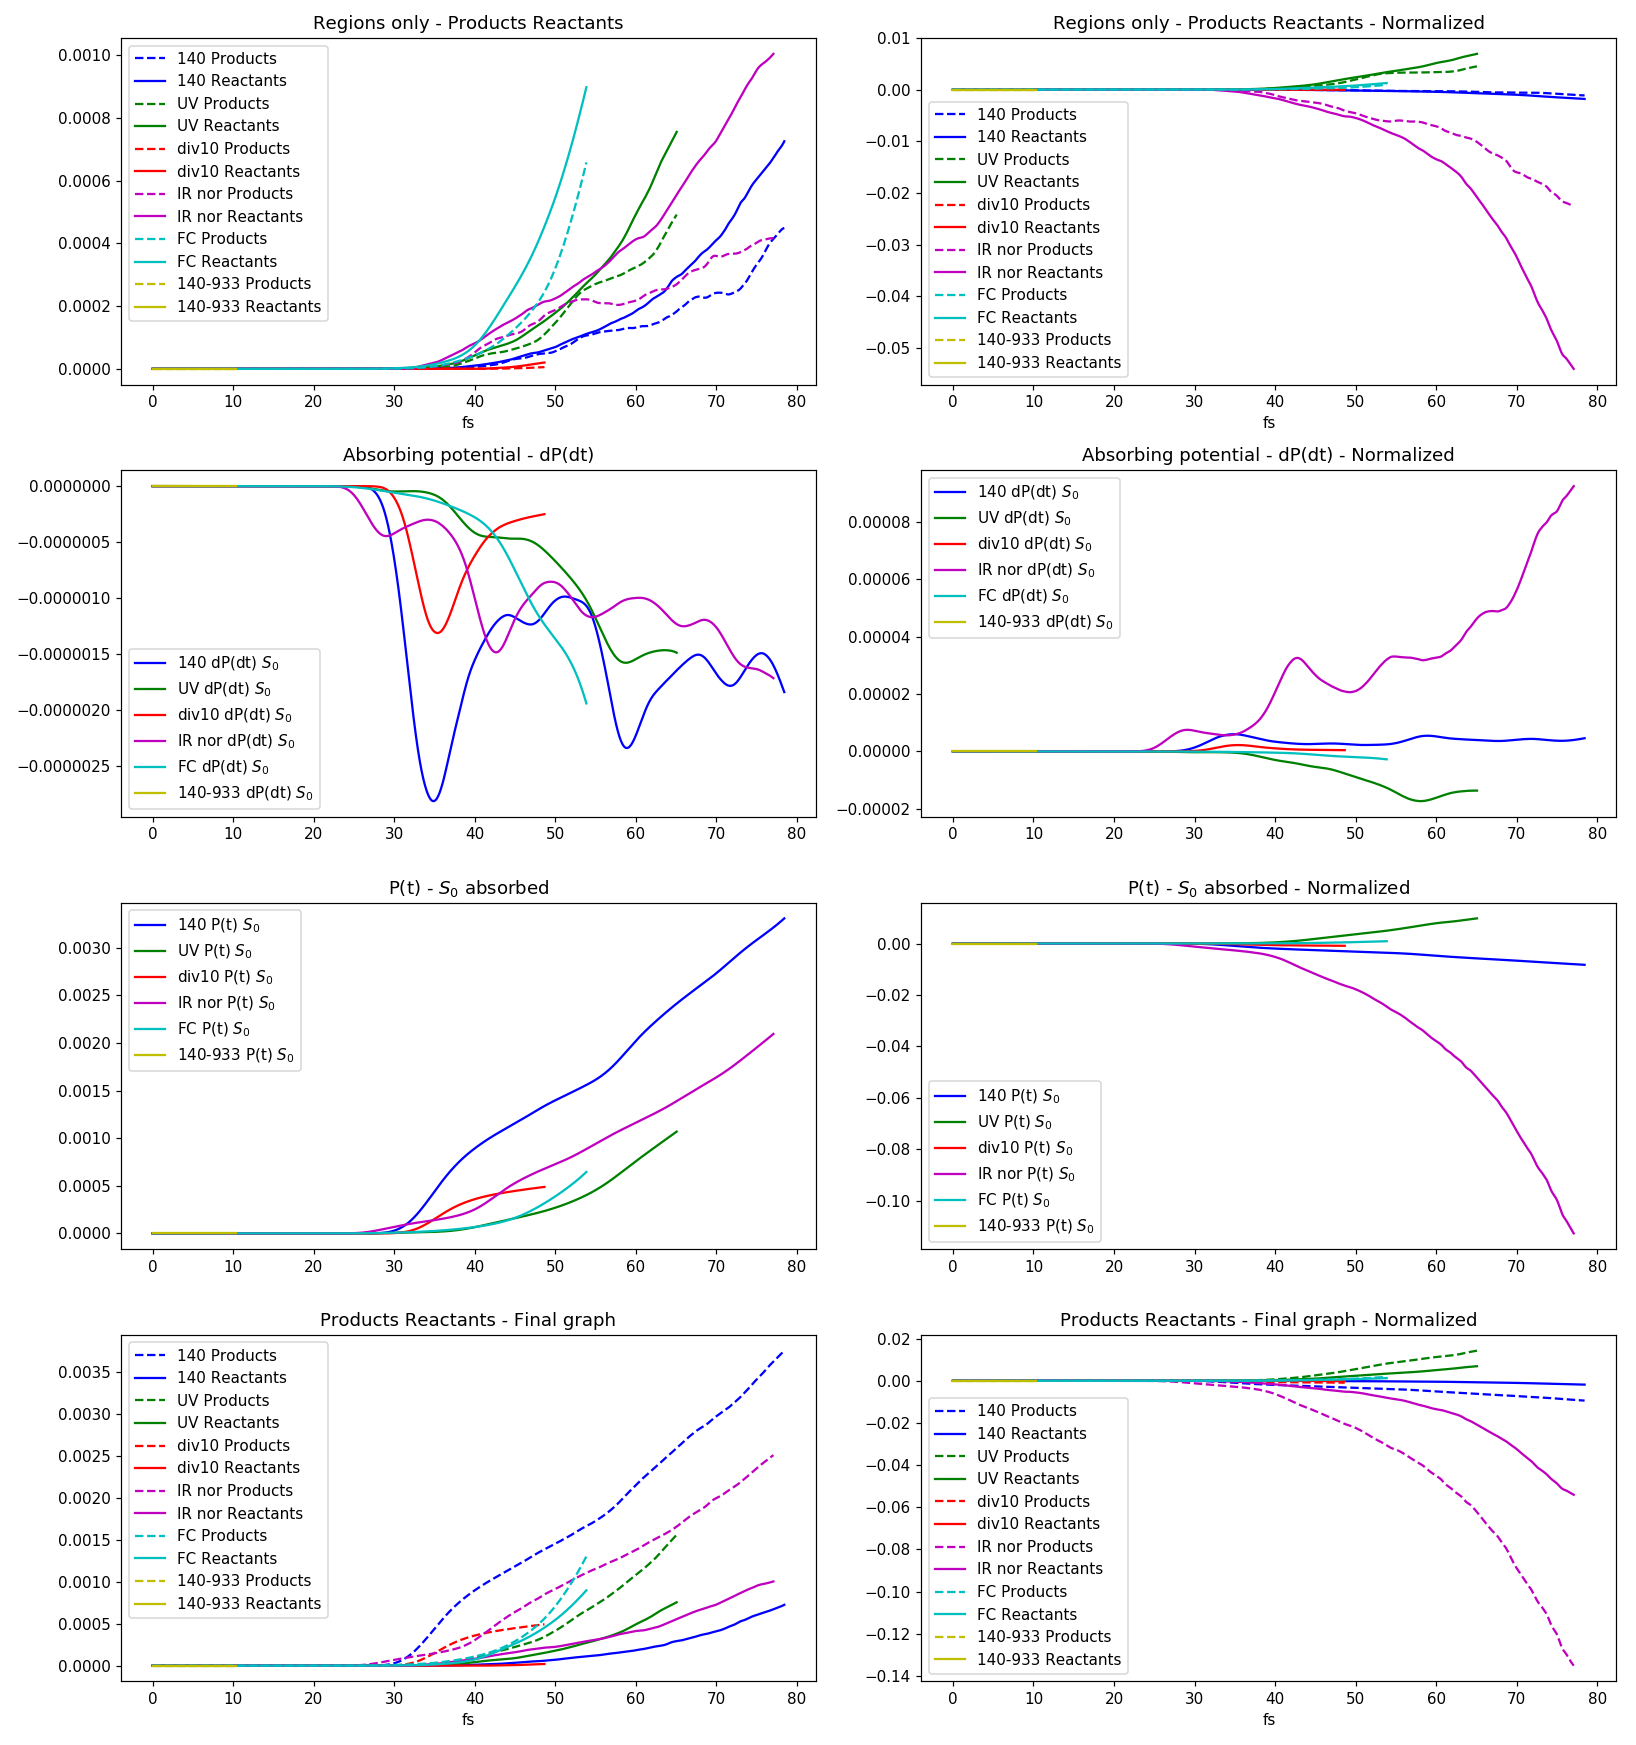

In [18]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(15,16))

# labelz = ['norm','count','inv','pi']
# runs = [c,d,e,f]

labelz = ['140','UV','div10','IR nor','FC','140-933']
runs = [a,b,c,d,e,f]


for ind,i in enumerate(runs):
    ax0.plot(i['fs'].iloc[:,1],  i['Products']    , label='{} Products'.format(labelz[ind]) , ls='--', color=colors[ind])
    ax0.plot(i['fs'].iloc[:,1],  i['Reactants']   , label='{} Reactants'.format(labelz[ind]),          color=colors[ind])
    #ax0.plot(i['fs'].iloc[:,1],  i['FC after pulse'], label='{} FC'.format(labelz[ind])       , ls=':', lw=0.5,  color=colors[ind])
    ax1.plot(i['fs'].iloc[:,1],  i['Products'] /i['Norm_factor (t)']    , label='{} Products'.format(labelz[ind]) , ls='--', color=colors[ind])
    ax1.plot(i['fs'].iloc[:,1],  i['Reactants']/i['Norm_factor (t)']    , label='{} Reactants'.format(labelz[ind]),          color=colors[ind])
    #ax1.plot(i['fs'].iloc[:,1],  i['FC after pulse']/i['Norm_factor (t)'], label='{} FC'.format(labelz[ind])       , ls=':', lw=0.5,  color=colors[ind])

ax0.set_xlabel('fs')
ax0.set_title('Regions only - Products Reactants')
ax0.legend()
ax1.set_xlabel('fs')
ax1.set_title('Regions only - Products Reactants - Normalized')
ax1.legend()

for ind,i in enumerate(runs):
    ax2.plot(i['fs'].iloc[:,1],     i['Abs S0'], label=r'{} dP(dt) $S_0$'.format(labelz[ind]), color=colors[ind])
    ax3.plot(i['fs'].iloc[:,1],     i['Abs S0']/i['Norm_factor (t)'], label=r'{} dP(dt) $S_0$'.format(labelz[ind]), color=colors[ind])

ax2.set_title('Absorbing potential - dP(dt)')
ax2.legend()
ax3.set_title('Absorbing potential - dP(dt) - Normalized')
ax3.legend()


for ind,i in enumerate(runs):
    ax4.plot(i['fs'].iloc[:,1],     i['P(t) S0'], label=r'{} P(t) $S_0$'.format(labelz[ind]), color=colors[ind])
    ax5.plot(i['fs'].iloc[:,1],     i['P(t) S0']/i['Norm_factor (t)'], label=r'{} P(t) $S_0$'.format(labelz[ind]), color=colors[ind])
    
ax4.set_title(r'P(t) - $S_0$ absorbed')
ax4.legend()
ax5.set_title(r'P(t) - $S_0$ absorbed - Normalized')
ax5.legend()

for ind,i in enumerate(runs):
    ax6.plot(i['fs'].iloc[:,1],     i['Products_F'] ,   label='{} Products'.format(labelz[ind]),  ls='--', color=colors[ind])
    ax6.plot(i['fs'].iloc[:,1],     i['Reactants_F'],   label='{} Reactants'.format(labelz[ind]), color=colors[ind])
    ax7.plot(i['fs'].iloc[:,1],     i['Products_F'] /i['Norm_factor (t)'],   label='{} Products'.format(labelz[ind]),  ls='--', color=colors[ind])
    ax7.plot(i['fs'].iloc[:,1],     i['Reactants_F']/i['Norm_factor (t)'],   label='{} Reactants'.format(labelz[ind]), color=colors[ind])

ax6.set_xlabel('fs')
ax6.set_title('Products Reactants - Final graph')
ax6.legend()
ax7.set_xlabel('fs')
ax7.set_title('Products Reactants - Final graph - Normalized')
ax7.legend()


fig.tight_layout();

In [20]:
a

,counter,steps,fs,Norm deviation,Kinetic,Potential,Total,Total Deviation,Xpulse,Ypulse,...,P(t) S1,P(t) S2,P(t) S3,P(t) S4,P(t) S5,P(t) S6,P(t) S7,AU_dt,Products_F,Reactants_F
0,0,0.000000,3.330669e-16,0.091654,0.091279,0.182933,0.000000e+00,6.018470e-07,-3.471030e-06,0.0,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,2.0671,2.203941e-65,1.284465e-34
1,100,0.050050,1.741657e-08,0.091655,0.091278,0.182933,7.449894e-09,1.788736e-07,-3.750248e-06,0.0,...,4.225028e-85,4.284416e-80,1.076033e-78,8.708796e-79,3.407201e-79,9.412995e-79,6.964804e-79,2.0671,3.190958e-64,1.852640e-28
2,200,0.100100,6.966591e-08,0.091659,0.091274,0.182933,2.999711e-08,-3.052015e-07,-3.988908e-06,0.0,...,6.500204e-80,4.733425e-78,1.475168e-76,1.580910e-74,2.352694e-73,2.509676e-73,4.209015e-73,2.0671,4.202142e-63,2.832082e-27
3,300,0.150150,1.567469e-07,0.091665,0.091268,0.182933,6.764404e-08,-8.483128e-07,-4.176538e-06,0.0,...,6.526580e-73,3.448031e-72,2.889283e-71,3.222769e-69,5.404994e-68,3.994096e-68,1.411592e-67,2.0671,1.944103e-62,1.364481e-26
4,400,0.200200,2.786577e-07,0.091673,0.091260,0.182933,1.203961e-07,-1.446858e-06,-4.302373e-06,0.0,...,6.770394e-66,3.470020e-65,1.694861e-64,7.385524e-63,2.429633e-62,4.420270e-62,9.934727e-63,2.0671,5.466042e-62,4.031901e-26
5,500,0.250250,4.353958e-07,0.091683,0.091249,0.182933,1.882638e-07,-2.095578e-06,-4.355556e-06,0.0,...,2.285298e-62,1.702558e-61,1.091462e-60,2.317462e-59,7.600655e-59,1.903757e-58,2.119890e-58,2.0671,1.143680e-61,9.012964e-26
6,600,0.300301,6.269577e-07,0.091696,0.091236,0.182933,2.712636e-07,-2.787452e-06,-4.325354e-06,0.0,...,3.070089e-59,1.782592e-58,2.172291e-57,3.350792e-56,1.077374e-55,2.669682e-55,2.855917e-55,2.0671,1.752891e-60,1.672060e-25
7,700,0.350351,8.533396e-07,0.091712,0.091221,0.182933,3.694163e-07,-3.513625e-06,-4.201413e-06,0.0,...,6.152314e-57,5.940274e-56,9.427049e-55,6.537059e-54,1.728447e-53,6.441136e-53,1.066751e-52,2.0671,3.068182e-58,2.702351e-25
8,800,0.400401,1.114537e-06,0.091729,0.091203,0.182932,4.827432e-07,-4.263360e-06,-3.974025e-06,0.0,...,1.283119e-55,3.103042e-54,3.084806e-53,9.888620e-53,2.383401e-52,2.071706e-51,5.527748e-51,2.0671,1.601605e-56,3.916653e-25
9,900,0.450451,1.410543e-06,0.091749,0.091183,0.182932,6.112599e-07,-5.024028e-06,-3.634422e-06,0.0,...,1.308913e-54,5.538744e-53,6.763889e-52,1.160090e-51,2.483976e-51,3.276091e-50,1.025376e-49,2.0671,2.704230e-55,5.198851e-25


<IPython.core.display.Javascript object>


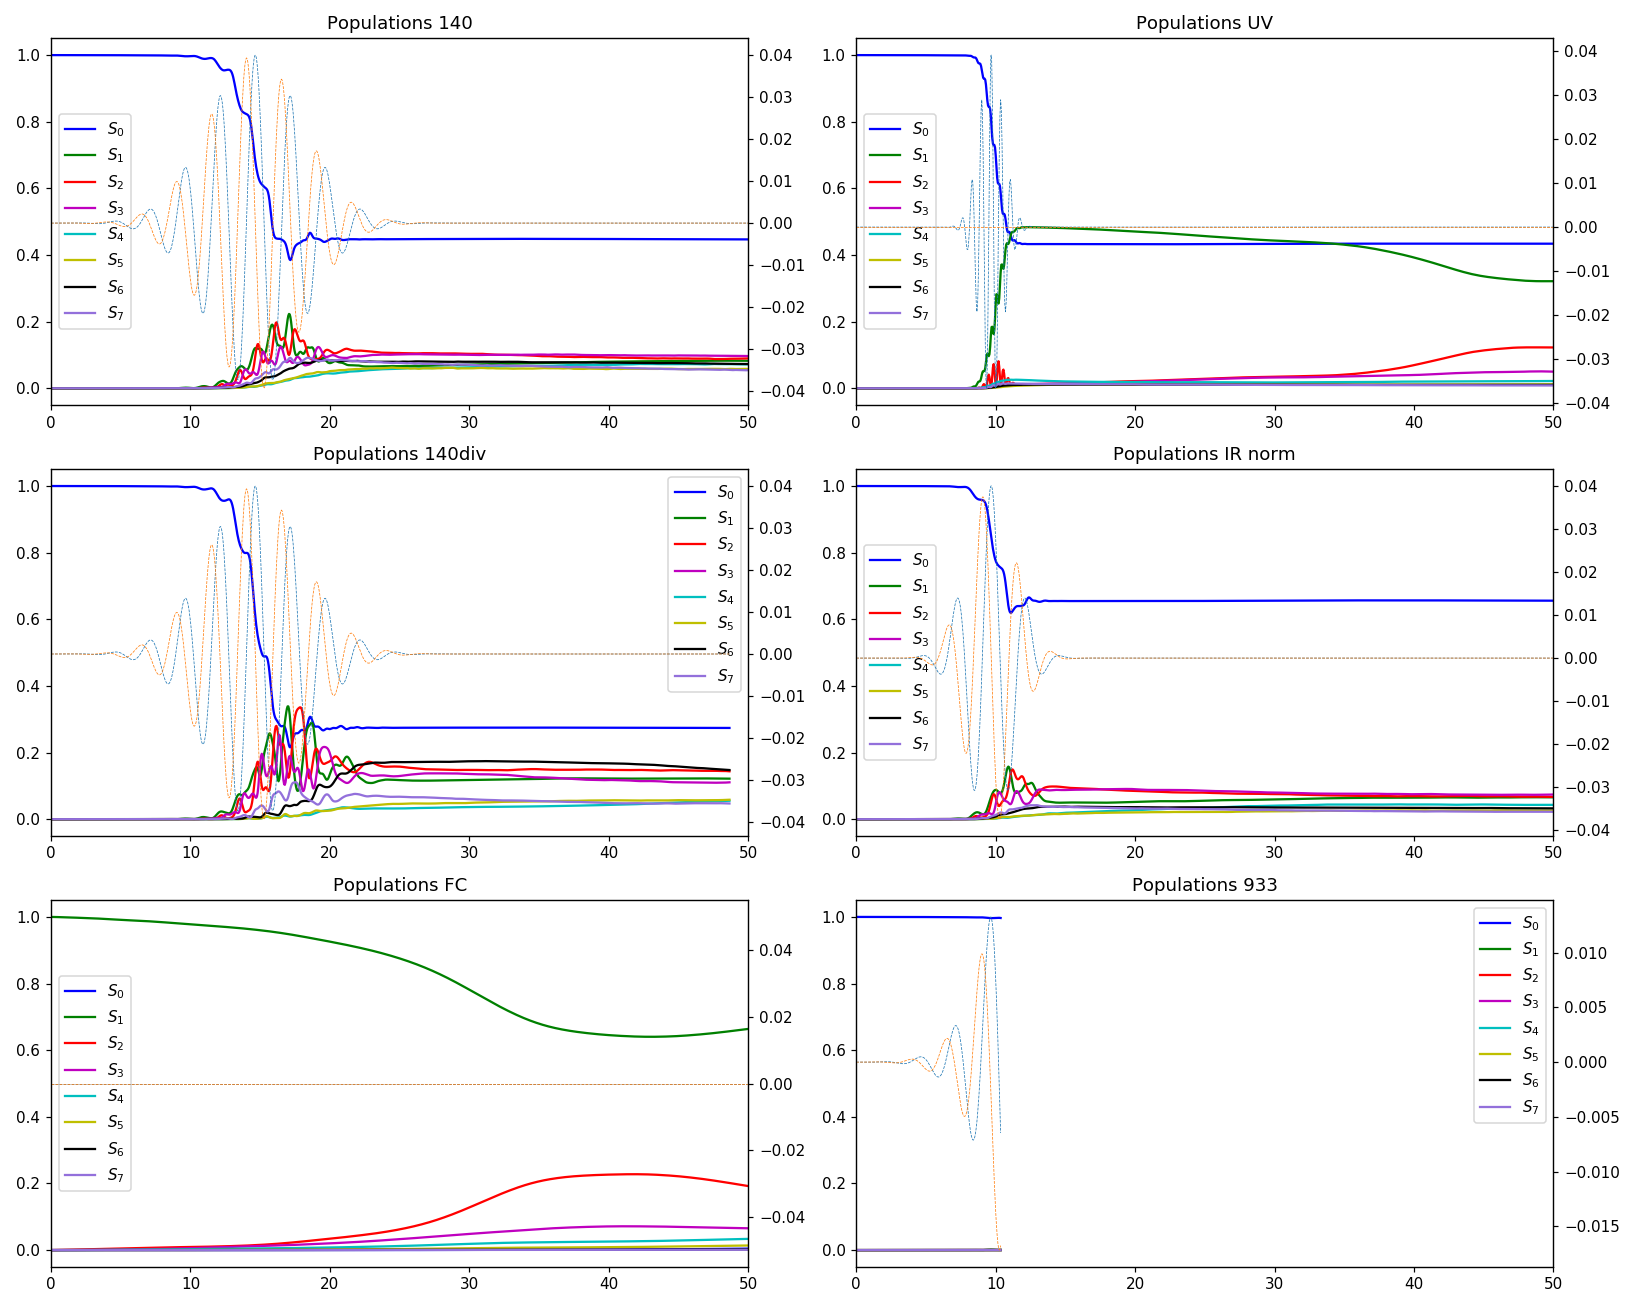

In [20]:
fig, [[ax4,ax5],[ax6,ax7],[ax8,ax9]] = plt.subplots(3,2,figsize=(15,12))

here = a
for state in [0,1,2,3,4,5,6,7]:
    ax4.plot(here['fs'].iloc[:,1], here['S{}'.format(state)], label=r'$S_{}$'.format(state), color=colors[state])

ax44 = ax4.twinx()
ax44.plot(here['fs'].iloc[:,1], here['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax44.plot(here['fs'].iloc[:,1], here['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax4.set_title('Populations 140')
ax4.set_xlim(0,50)
ax4.legend()

here = b
for state in [0,1,2,3,4,5,6,7]:
    ax5.plot(here['fs'].iloc[:,1], here['S{}'.format(state)], label=r'$S_{}$'.format(state), color=colors[state])

ax55 = ax5.twinx()
ax55.plot(here['fs'].iloc[:,1], here['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax55.plot(here['fs'].iloc[:,1], here['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax5.set_title('Populations UV')
ax5.set_xlim(0,50)
ax5.legend()

here = c
for state in [0,1,2,3,4,5,6,7]:
    ax6.plot(here['fs'].iloc[:,1], here['S{}'.format(state)], label=r'$S_{}$'.format(state), color=colors[state])

ax66 = ax6.twinx()
ax66.plot(here['fs'].iloc[:,1], here['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax66.plot(here['fs'].iloc[:,1], here['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax6.set_title('Populations 140div')
ax6.set_xlim(0,50)
ax6.legend()

here = d
for state in [0,1,2,3,4,5,6,7]:
    ax7.plot(here['fs'].iloc[:,1], here['S{}'.format(state)], label=r'$S_{}$'.format(state), color=colors[state])

ax77 = ax7.twinx()
ax77.plot(here['fs'].iloc[:,1], here['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax77.plot(here['fs'].iloc[:,1], here['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax7.set_title('Populations IR norm')
ax7.set_xlim(0,50)
ax7.legend()

here = e
for state in [0,1,2,3,4,5,6,7]:
    ax8.plot(here['fs'].iloc[:,1], here['S{}'.format(state)], label=r'$S_{}$'.format(state), color=colors[state])

ax88 = ax8.twinx()
ax88.plot(here['fs'].iloc[:,1], here['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax88.plot(here['fs'].iloc[:,1], here['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax8.set_title('Populations FC')
ax8.set_xlim(0,50)
ax8.legend()

here = f
for state in [0,1,2,3,4,5,6,7]:
    ax9.plot(here['fs'].iloc[:,1], here['S{}'.format(state)], label=r'$S_{}$'.format(state), color=colors[state])

ax99 = ax9.twinx()
ax99.plot(here['fs'].iloc[:,1], here['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax99.plot(here['fs'].iloc[:,1], here['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax9.set_title('Populations 933')
ax9.set_xlim(0,50)
ax9.legend()

fig.tight_layout();